## Covid19 Analysis & Forecast
##### by Khairul Omar

### 1. Import data

In [1]:
# Import libraries
import pandas as pd
pd.options.display.max_rows = 300
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to fetch data
def fetch_data(month, date):
    url   = f'https://covid19.mathdro.id/api/daily/{month}-{date}-2020'
    r = requests.get(url)
    r.encoding = 'utf-8-sig'
    data = r.json()
    df = pd.DataFrame(data)
    if '\ufeffprovinceState' in df.columns:
        df = df.rename(columns={'\ufeffprovinceState':'provinceState'})
    df = df[['countryRegion','provinceState','confirmed','deaths','recovered']]
    for col in ['confirmed','deaths','recovered']:
        df[col] = df[col].astype(int)
    zero = 0 if date < 10 else ''
    df['date'] = pd.to_datetime(f'20200{month}{zero}{date}00', format='%Y%m%d%H', errors='ignore')
    df = df.set_index('date')
    return df

In [3]:
# Fetch Feb data
df_feb = pd.DataFrame()
for day in range(1,29+1):
    rec = fetch_data(2, day)
    df_feb = pd.concat([df_feb, rec])

# Latest Mar date
day = 14

# Fetch Mar data to date
df_mar = pd.DataFrame()
for day in range(1,day+1):
    rec = fetch_data(3, day)
    df_mar = pd.concat([df_mar, rec])

df0 = pd.concat([df_feb, df_mar])
df0 = df0.sort_values('confirmed', ascending=False)
df0 = df0.sort_index(ascending=False)
df0 = df0.rename(columns={'countryRegion':'country'})

In [4]:
df1 = df0.copy()

# Geo clean-up mapping dictionary
geo = json.load(open('geo.json'))
df1.country = df1.country.apply(lambda row: geo['countries'][row] if row in list(geo['countries'].keys()) else row)
df2 = df1.copy()

# National data
df1 = pd.pivot_table(df1, values=['confirmed','deaths','recovered'], index=['date','country'], columns=None, aggfunc='sum')
df1 = df1.reset_index()
dftemp = pd.DataFrame()
for country in df1.country.unique():
    dfcountry = df1[df1.country==country].copy()
    dfcountry = dfcountry.sort_index(ascending=False)
    for col in ['confirmed','deaths','recovered']:
        colname = f'new_{col}'
        dfcountry[colname] = dfcountry[col].diff(-1)
        dfcountry[colname] = dfcountry[colname].fillna(dfcountry[col])
        dfcountry[colname] = dfcountry[colname].astype('int')
    dftemp =  pd.concat([dftemp, dfcountry])
df1 = dftemp.sort_values(['date','confirmed'], ascending=False)
df1 = df1.set_index('date')

### 2. Analyse latest data


Top 20 countries as of 14/3/2020


,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-03-14,China,80977,3193,65660,32,13,1464
2020-03-14,Italy,21157,1441,1966,3497,175,527
2020-03-14,Iran,12729,611,2959,1365,97,0
2020-03-14,South Korea,8086,72,510,107,6,0
2020-03-14,Spain,6391,195,517,1159,62,324
2020-03-14,Germany,4585,9,46,910,2,0
2020-03-14,France,4480,91,12,813,12,0
2020-03-14,United States,2726,54,12,547,7,0
2020-03-14,Switzerland,1359,13,4,220,2,0



New confirmed cases from 1/2/2020 to 14/3/2020


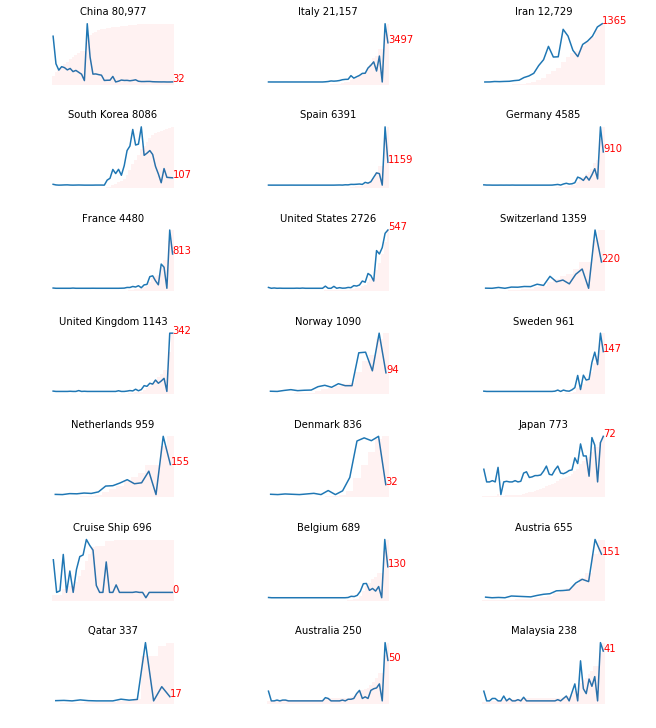

<Figure size 432x288 with 0 Axes>

In [111]:
# Display one day data
day   = day
month = 3
zero = 0 if day < 10 else ''
date = pd.to_datetime(f'20200{month}{zero}{day}00', format='%Y%m%d%H')
oneday = pd.Timedelta(1, unit='days')
latest = df1.loc[date]
print(f'\nTop 20 countries as of {date.day}/{date.month}/2020')
display(latest[:20])

# Select diplay data
until = date
data = df1[until:]

# Plot data
print(f'\nNew confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
countries = list(latest[:20].country) + ['Malaysia']
fig, axes = plt.subplots(ncols=3, nrows=round(len(countries)/3), figsize=(9,10), constrained_layout=True)
for i, ax in zip(range(len(countries)), axes.flat):
    cdata = data[data.country==countries[i]]
    ax.plot(cdata.new_confirmed)
    ax.text(until, cdata.loc[until].new_confirmed, cdata.loc[until].new_confirmed, color='red')
    ax2 = ax.twinx()
    ax2.bar(cdata.index, cdata.confirmed, color='red', alpha=0.05, width=1)
    clabel = f'{str(cdata.loc[until].confirmed)[:2]},{str(cdata.loc[until].confirmed)[2:]}' if cdata.loc[until].confirmed > 9999 else cdata.loc[until].confirmed
    ax.set_title(f'{countries[i]} {clabel}', fontsize=10)
    ax.axis('off')
    ax2.axis('off')
plt.show()
plt.savefig('top20.png')

### 3. ARIMA time series forecasting

Validate stationarity from time shifts
Shift d=1: adfuller:0.5, mean:1.9
Shift d=2: adfuller:0.001, mean:0.5
Shift d=3: adfuller:0.0, mean:0.0
Shift d=4: adfuller:0.0, mean:-0.8


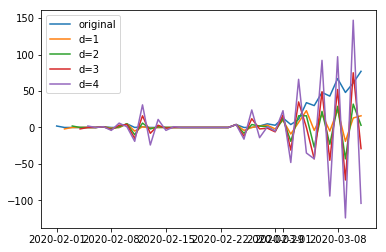

In [101]:
dfuk0 = df1[df1.country=='United Kingdom'].new_confirmed.sort_index()

# Select relevant period for model input
dfuk  = dfuk0[:-3]

# Shift data
dfuk1  = dfuk - dfuk.shift(1)
dfuk2  = dfuk1 - dfuk1.shift(1)
dfuk3  = dfuk2 - dfuk2.shift(1)
dfuk4  = dfuk3 - dfuk3.shift(1)
print(f'Validate stationarity from time shifts')
print(f'Shift d=1: adfuller:{round(adfuller(dfuk1[1:])[1],3)}, mean:{round(np.nanmean(dfuk1),1)}')
print(f'Shift d=2: adfuller:{round(adfuller(dfuk2[2:])[1],3)}, mean:{round(np.nanmean(dfuk2),1)}')
print(f'Shift d=3: adfuller:{round(adfuller(dfuk3[3:])[1],3)}, mean:{round(np.nanmean(dfuk3),1)}')
print(f'Shift d=4: adfuller:{round(adfuller(dfuk4[4:])[1],3)}, mean:{round(np.nanmean(dfuk4),1)}')

plt.plot(dfuk, label='original')
plt.plot(dfuk1, label='d=1')
plt.plot(dfuk2, label='d=2')
plt.plot(dfuk3, label='d=3')
plt.plot(dfuk4, label='d=4')
plt.legend()
plt.show()

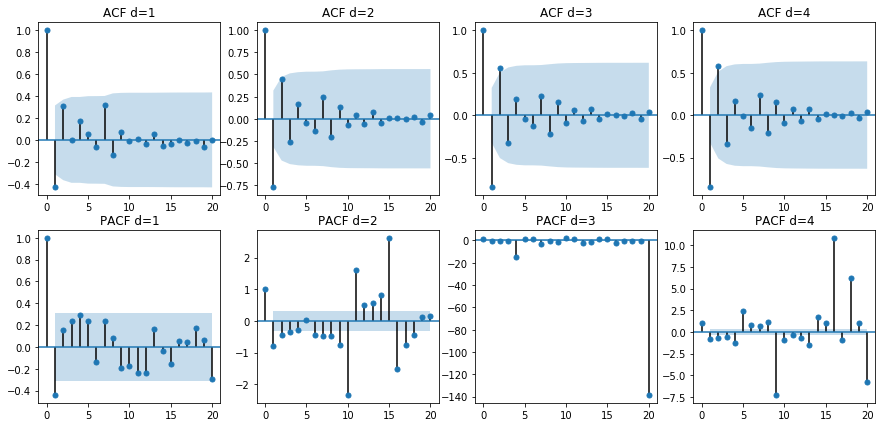

In [102]:
# Check ACF & PCF
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15,7))
plot_acf(dfuk1[1:], lags=20, ax=axes.flat[0], title='ACF d=1')
plot_acf(dfuk2[2:], lags=20, ax=axes.flat[1], title='ACF d=2')
plot_acf(dfuk3[3:], lags=20, ax=axes.flat[2], title='ACF d=3')
plot_acf(dfuk4[4:], lags=20, ax=axes.flat[3], title='ACF d=4')
plot_pacf(dfuk1[1:], lags=20, ax=axes.flat[4], title='PACF d=1')
plot_pacf(dfuk2[2:], lags=20, ax=axes.flat[5], title='PACF d=2')
plot_pacf(dfuk3[3:], lags=20, ax=axes.flat[6], title='PACF d=3')
plot_pacf(dfuk4[4:], lags=20, ax=axes.flat[7], title='PACF d=4');

In [104]:
# Run model
p, d, q = 1, 2, 1
sarima = SARIMAX(dfuk, order=(p, d, q),
                enforce_stationarity=False).fit()
# print(sarima.summary())
# sarima.plot_diagnostics(figsize=(12,7));

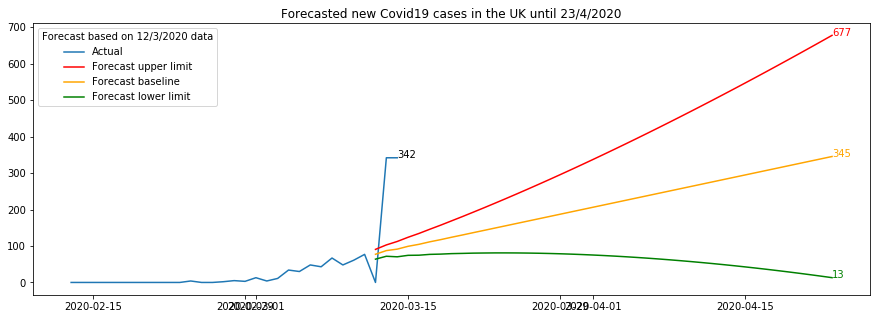

<Figure size 432x288 with 0 Axes>

In [112]:
# Set plotting periods
test_start = dfuk.index.max() + oneday
test_end   = test_start + oneday * 7*6
act_start  = test_start - oneday * 7*4
pred = sarima.predict(start=test_start, end=test_end, dynamic=True)
pred_conf = sarima.get_forecast(len(pred)).conf_int()
upper = pred_conf.iloc[:,1]
lower = pred_conf.iloc[:,0].clip(0)

# Plot data
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(dfuk0[act_start:], label='Actual')
plt.plot(upper, label='Forecast upper limit', c='red')
plt.plot(pred, label='Forecast baseline', c='orange')
plt.plot(lower, label='Forecast lower limit', c='green')
plt.text(dfuk0.index.max(), dfuk0[-1], dfuk0[-1])
plt.text(test_end, int(upper.iloc[-1]), int(upper.iloc[-1]), color='red')
plt.text(test_end, int(pred.iloc[-1]), int(pred.iloc[-1]), color='orange')
plt.text(test_end, int(lower.iloc[-1]), int(lower.iloc[-1]), color='green')

# plt.fill_between(pred.index, pred_conf.iloc[:,1], pred_conf.iloc[:,0].clip(0), color='r', alpha=.05, label='ARIMA confidence interval');
plt.legend(loc='upper left', title=f'Forecast based on {test_start.day}/{test_start.month}/2020 data')
ax.set_title(f'Forecasted new Covid19 cases in the UK until {test_end.day}/{test_end.month}/2020')
plt.show()
plt.savefig('forecast_uk.png')

### 4. Sub-national level data

In [19]:
df2 = df0.copy()

# Geo clean-up mapping dictionary
geo = json.load(open('geo.json'))
df2.country = df2.country.apply(lambda row: geo['countries'][row] if row in list(geo['countries'].keys()) else row)
df2['temp'] = ''
for i in range(len(df2)):
    provinceState = df2.iloc[i].provinceState
    country = df2.iloc[i].country
    if provinceState in ['Faroe Islands', 'French Polynesia', 'Channel Islands', 'Gibraltar',
                         'Saint Barthelemy', 'St Martin']:
        df2.iloc[i, df2.columns.get_loc('country')] = df2.iloc[i, df2.columns.get_loc('provinceState')]
        df2.iloc[i, df2.columns.get_loc('provinceState')] = country
    elif (provinceState == country) | (provinceState == 'None') | (provinceState == 'UK'):
        df2.iloc[i, df2.columns.get_loc('provinceState')] = country
    elif provinceState.find('d Princess') > 0:
        if country == 'Israel':
            df2.iloc[i, df2.columns.get_loc('provinceState')] = 'Diamond Princess Israel'
        else:
            df2.iloc[i, df2.columns.get_loc('provinceState')] = 'Diamond Princess'
    elif country == 'United States':
        if provinceState == 'Washington, D.C.':
            s = 'DC'
        elif provinceState.find('Princess') > 0:
            s = 'Cruise Ship'
        elif provinceState.find(', ') > 0:
            s = provinceState[provinceState.find(', ')+2:provinceState.find(', ')+4]
        elif provinceState in list(geo['us_states'].keys()):
            s = geo['us_states'][provinceState]
        else:
            s = provinceState
        df2.iloc[i, df2.columns.get_loc('temp')] = s
    elif country == 'Canada':
        if provinceState.find('Princess') > 0:
            s = 'Cruise Ship'      
        elif provinceState.find(', ') > 0:
            ca = {'Edmonton, Alberta':'Alberta', 'Calgary, Alberta':'Alberta',
                  'London, ON':'Ontario', 'Toronto, ON':'Ontario', ' Montreal, QC':'Quebec'}
            s = ca[provinceState]
        else:
            s = provinceState
        df2.iloc[i, df2.columns.get_loc('temp')] = s

df2['provinceState'] = df2.apply(lambda row: row['temp'] if row['temp']!='' else (row['provinceState'] if row['provinceState']!='' else row['country']), axis=1)
df2.drop('temp', axis=1, inplace=True)

df2 = pd.pivot_table(df2, values=['confirmed','deaths','recovered'], index=['date','country','provinceState'], columns=None, aggfunc='sum')
df2 = df2.reset_index()
dftemp = pd.DataFrame()
for state in df2.provinceState.unique():
    dfstate = df2[df2.provinceState==state].copy()
    dfstate = dfstate.sort_index(ascending=False)
    for col in ['confirmed','deaths','recovered']:
        colname = f'new_{col}'
        dfstate[colname] = dfstate[col].diff(-1)
        dfstate[colname] = dfstate[colname].fillna(dfstate[col])
        dfstate[colname] = dfstate[colname].astype('int')
    dftemp =  pd.concat([dftemp, dfstate])
df2 = dftemp.sort_values(['date','confirmed'], ascending=False)
df2 = df2.set_index('date')

In [20]:
df2[df2.provinceState=='Beijing']

,country,provinceState,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,,
2020-03-14,China,Beijing,437,8,349,1,0,7
2020-03-13,China,Beijing,436,8,342,1,0,8
2020-03-12,China,Beijing,435,8,334,0,0,8
2020-03-11,China,Beijing,435,8,326,6,0,6
2020-03-10,China,Beijing,429,8,320,1,0,5
2020-03-09,China,Beijing,428,8,315,0,0,7
2020-03-08,China,Beijing,428,8,308,2,0,5
2020-03-07,China,Beijing,426,8,303,4,0,4
2020-03-06,China,Beijing,422,8,299,4,0,2


In [12]:
# skip = ['China','United States','Canada','Australia']
# temp = df2[~df2.country.isin(skip)]
# temp[temp.provinceState!='']